In [1]:
import pandas as pd
import numpy as np
from skimage import io, transform
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import os
import os.path
import matplotlib.pyplot as plt
import cv2
plt.ion()  

D:\Programs\anaconda\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 127] 找不到指定的程序。
  warn(f"Failed to load image Python extension: {e}")


In [2]:
def showimg(url):
    """Show image """
    plt.imshow(io.imread(url),cmap='gray', vmin=0, vmax=255)
    plt.pause(0.001)  # pause a bit so that plots are updated

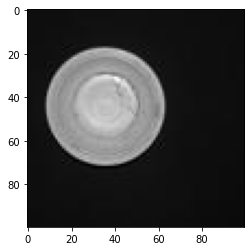

In [3]:
showimg('imgs2/imgxy/25.jpg')

In [4]:
def to_one_hot(Y): 
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized
to_one_hot([1,2,3,0])

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]])

In [5]:
def int21hot(n,num): #another int to one-hot array function
    ret=np.zeros(num)
    ret[n-1]=1
    return ret
int21hot(2,5)

array([0., 1., 0., 0., 0.])

In [6]:
def getFirstInt(content): #get the first integer number of a string, used for obtaining hand number from image names
    intchars=[]
    intstarted=False
    intended=False
    for i in range(len(content)):
        if content[i].isdigit():
            intchars.append(content[i])
            intstarted=True
        if intstarted:
            if not content[i].isdigit():
                intended=True
        if intstarted and intended:
            break
    return int(''.join(intchars))
getFirstInt('21.jpg')

21

In [7]:
#read additional data for each sample and labels 
#category,centx,centy,w,h are inputs
#x,y,z,angx,angy,angz are labeled outputs
xdf=pd.read_csv('extradata2acwh.csv')
xdf=xdf.drop('Unnamed: 0',axis=1)
maxctg=max(xdf.loc[:,'category'])
leng=xdf.shape[0]
xdf

,category,centx,centy,w,h,x,y,z,angx,angy,angz
0,4,71.0,62.0,28,26,40.15,34.65,19,0,0,0
1,1,76.0,58.0,46,52,29.70,31.35,3,0,0,75
2,1,25.5,58.5,51,51,2.75,31.90,3,0,0,75
3,1,30.0,22.5,52,45,5.50,10.45,3,0,0,75
4,1,69.0,21.0,52,42,26.40,9.35,3,0,0,75
...,...,...,...,...,...,...,...,...,...,...,...
118,6,27.0,62.0,22,22,15.40,34.10,4,0,0,0
119,6,77.0,77.0,22,22,42.90,42.35,4,0,0,0
120,6,78.5,41.0,23,22,43.45,22.55,4,0,0,0
121,6,26.0,72.0,22,22,14.30,39.60,4,0,0,0


In [8]:
from torch.utils.data import Dataset, DataLoader
failcount=0
labelcols=[5,6,7,8,9,10] #select columns for labels from xdf
conticols=[1,2,3,4] #select columns of continuous inputs: centx,centy,w,h
class WareDataset(Dataset): 
    def __init__(self, main_dir, transform=None):
        self.main_dir=main_dir
        self.subdirs=os.listdir(self.main_dir)
        self.transform=transform
        self.labeldf=pd.DataFrame(columns=['name','label','path'])
        self.count=0
        imgnames=os.listdir(main_dir)
        for name in range(leng):
            mypathxy=os.path.join(main_dir,'imgxy',str(name)+'.jpg')
            mypathxz=os.path.join(main_dir,'imgxz',str(name)+'.jpg')
            #put all information for each sample in a dic,except images
            #at this stage images only have their dirs saved in order to save memory
            #images will be retrieved when _getitem() is called
            appdic={'name':name,'label':np.array(list(xdf.iloc[name,labelcols])),'path':[mypathxy,mypathxz]}
            self.labeldf=self.labeldf.append(appdic,ignore_index=True)
            self.count+=1
                
    def __len__(self):
        return self.count
    
    def setLen(self,leng):
        self.count=leng
    
    def __getitem__(self,idx):
        global failcount
        img_paths = self.labeldf.loc[idx,'path']
        imagexy = io.imread(img_paths[0])
        imagexz = io.imread(img_paths[1])
        ima,imb=imagexy.shape
        label = self.labeldf.loc[idx, 'label']
        #we have 2 100*100 images, one 1*6 one-hot vector and one 1*4 bound box vector as inputs
        #To put all of them in one tensor, we create a 3*100*100 array
        #in this array, two of the three layers are two images, respectively
        #another layer has its first two rows to store the two vectors and the rest are zeros
        newimg=np.array([imagexy,np.zeros(imagexy.shape),imagexz])
        catemax=np.max(xdf.loc[:,'category'])
        newimg[1,0,0:catemax]=int21hot(xdf.loc[idx,'category'],catemax)
        newimg[1,1,0:len(conticols)]=np.array(xdf.loc[idx,:][conticols])
        return torch.tensor(newimg),torch.tensor(label)
            
    def getitems(self,idxs): #return multiple pairs of image tensors and label tensors in a list of tuples
        ret=[]
        for idx in idxs:
            ret.append(self[idx])
        return ret
        
    def getlabeldf(self):
        return self.labeldf

In [9]:
#This function creates train, validation and test dataloaders from a dataset
gltrvalset=None
def get_data_loader(batch_size,dataset,ttratio):
    failcount=0
    gdset=dataset
    gdlabeldf=gdset.getlabeldf()
    names=gdlabeldf.loc[:,'name']
    leng,wid=xdf.shape
    testnum=int(round((1-ttratio)*leng))
    testdexs=[]
    trvaldexs=list(range(leng)) #indices for train and validation
    #randomly generate indices for test dataset
    while len(testdexs)<testnum:
        mydex=np.random.randint(leng)
        if not mydex in testdexs:
            testdexs.append(mydex)
    #train and validation dataset indices
    for n in testdexs:
        trvaldexs.remove(n)
    trvalset=gdset.getitems(trvaldexs)
    global gltrvalset
    gltrvalset=trvalset
    testset=gdset.getitems(testdexs)
    print('length of training set:',len(trvalset))
    print('length of testset:',len(testset))
    #split for train and validation datasets
    split = int(len(trvaldexs) * 0.8)
    trvalredexs=list(range(0,len(trvaldexs))) #reset train&validate set indices
    np.random.seed(1000)
    np.random.shuffle(trvalredexs)
    traindexs,valdexs=trvalredexs[:split],trvalredexs[split:]
    train_sampler = SubsetRandomSampler(traindexs)
    train_loader = torch.utils.data.DataLoader(trvalset, batch_size=batch_size,
                                               num_workers=0, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(valdexs)
    val_loader = torch.utils.data.DataLoader(trvalset, batch_size=batch_size,
                                              num_workers=0, sampler=val_sampler)
    test_sampler = SubsetRandomSampler(list(range(0,len(testdexs)))) #reset test_loader indices
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=0, sampler=test_sampler)
    return train_loader, val_loader, test_loader

In [85]:
#try generating dataloaders and check them
wdset=WareDataset('imgs2')
trloader,valloader,testloader=get_data_loader(10,wdset,0.7)

C:\Users\Czr19\AppData\Local\Temp/ipykernel_19708/3001992461.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.labeldf=self.labeldf.append(appdic,ignore_index=True)
C:\Users\Czr19\AppData\Local\Temp/ipykernel_19708/3001992461.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.labeldf=self.labeldf.append(appdic,ignore_index=True)
C:\Users\Czr19\AppData\Local\Temp/ipykernel_19708/3001992461.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.labeldf=self.labeldf.append(appdic,ignore_index=True)
C:\Users\Czr19\AppData\Local\Temp/ipykernel_19708/3001992461.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.labeld

length of training set: 86
length of testset: 37


In [11]:
for a,b in trloader:
    print(b.shape)
    print(b)
    break

torch.Size([10, 6])
tensor([[38.5000, 16.5000,  4.0000,  0.0000,  0.0000, 15.0000],
        [ 1.6500, 28.6000,  3.0000,  0.0000,  0.0000, 75.0000],
        [27.5000, 29.7000,  8.0000,  0.0000,  0.0000,  0.0000],
        [24.7500, 32.4500, 14.0000,  0.0000,  0.0000,  0.0000],
        [31.9000, 45.6500, 13.0000,  0.0000,  0.0000,  0.0000],
        [15.4000, 34.1000,  4.0000,  0.0000,  0.0000,  0.0000],
        [ 5.5000, 48.9500, 18.0000,  0.0000,  0.0000,  0.0000],
        [ 6.6000, 34.6500,  3.0000,  0.0000,  0.0000, 75.0000],
        [ 7.7000, 21.4500,  3.0000,  0.0000,  0.0000, 75.0000],
        [28.6000, 32.4500, 15.0000,  0.0000,  0.0000,  0.0000]],
       dtype=torch.float64)


In [12]:
def rmse(predictions, targets): #calculate RMSE between two vectors
    return np.sqrt(((predictions.detach().numpy() - targets.detach().numpy()) ** 2).mean())

In [13]:
ctgfc1size=7
bbsfc1size=5
xyzfc2size=5
class CNNnet(nn.Module):
    def __init__(self):
        super(CNNnet, self).__init__()
        self.name = "cnn"
        self.conv1 = nn.Conv2d(1, 5, 5,padding=2) #1*100*100->5*100*100
        self.pool = nn.MaxPool2d(2, 2) #5*100*100->5*50*50
        self.conv2 = nn.Conv2d(5, 10, 5,padding=2) #5*50*50->10*50*50
        self.xyzfc1 = nn.Linear(10*25*25*2+ctgfc1size+bbsfc1size, hiddensize)
        self.angfc1=nn.Linear(10*25*25*2+ctgfc1size+bbsfc1size+xyzfc2size, hiddensize)
        self.fc2 = nn.Linear(hiddensize, 3)
        self.ctgfc1=nn.Linear(maxctg,ctgfc1size)
        self.bbsfc1=nn.Linear(len(conticols),bbsfc1size)
        self.xyzfc2=nn.Linear(3,xyzfc2size)

    def forward(self, x):
        # extract each image and each vector from the input 3*100*100 tensor
        ximgxy=x[:,0,:,:][:,None]
        ximgxz=x[:,2,:,:][:,None]
        xctg=x[:,1,0,0:maxctg]
        xbbs=x[:,1,1,0:len(conticols)]
        #structure
        #print('ximg:',ximg)
        x0=self.conv1(ximgxy)
        #print('conv1 ximg:',x)
        x0 = self.pool(F.relu(x0))
        x0 = self.pool(F.relu(self.conv2(x0))) 
        x0 = x0.view(-1, 10*25*25)
        x2=self.conv1(ximgxz)
        #print('conv1 ximg:',x)
        x2 = self.pool(F.relu(x2))
        x2 = self.pool(F.relu(self.conv2(x2))) 
        x2 = x2.view(-1, 10*25*25)
        xctg=F.relu(self.ctgfc1(xctg))
        xbbs=F.relu(self.bbsfc1(xbbs))
        xxyz=torch.cat((x0,x2,xctg,xbbs),1)
        #print('x size after cat:',x.shape)
        xxyz = F.relu(self.xyzfc1(xxyz))
        xxyz = self.fc2(xxyz)
        xxyz = xxyz.squeeze(1) # Flatten to [batch_size]
        xxyz2=F.relu(self.xyzfc2(xxyz))
        xang=torch.cat((x0,x2,xctg,xbbs,xxyz2),1)
        xang=F.relu(self.angfc1(xang))
        xang=self.fc2(xang)
        xang=xang.squeeze(1)
        return torch.cat((xxyz,xang),1)

In [14]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def evaluate(net, loader, criterion):
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr=rmse(labels,outputs)
        total_err += corr
        total_loss += loss.item()
        total_epoch += len(labels) 
    err = float(total_err) / total_epoch 
    loss = float(total_loss) / (i + 1)
    return err, loss

def plot_training_curve(path):
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [95]:
import time
def train_net(net,train_loader,val_loader, batch_size=64, learning_rate=0.01, num_epochs=30,retain_graph=False):
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be MSE loss for continuous outputs
    # Optimizer will be SGD with Momentum.
    criterion = nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    epochcount=0
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        #print('current epoch:',epochcount)
        epochcount+=1
        i=0
        for inputs,labels in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.double())
            loss.backward() #dloss/dx
            optimizer.step()
            # Calculate the statistics
            corr=rmse(labels,outputs)
            total_train_err += corr
            total_train_loss += loss.item()
            total_epoch += len(labels)
            i+=1
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
        
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

In [127]:
hiddensize=128
cnn = CNNnet()
cnn=cnn.double()

In [128]:
bsize=20 #batch size
lrate=0.000005 #learning rate
numep=50 #num of epochs
train_loader, val_loader, test_loader = get_data_loader(bsize,wdset,0.9)
train_net(cnn,train_loader, val_loader,batch_size=bsize, learning_rate=lrate, num_epochs=numep)

length of training set: 111
length of testset: 12
Epoch 1: Train err: 1.441658329970738, Train loss: 560.6499764085091 |Validation err: 2.3218618774343596, Validation loss: 765.817545470547
Epoch 2: Train err: 1.263004816782532, Train loss: 423.743790238539 |Validation err: 1.7034840088805694, Validation loss: 385.8010636059081
Epoch 3: Train err: 1.1937284335868321, Train loss: 374.63387090027385 |Validation err: 2.335531614372515, Validation loss: 819.6560718771784
Epoch 4: Train err: 1.0630608808204463, Train loss: 297.4896020143677 |Validation err: 2.0968197607641863, Validation loss: 614.3995198389749
Epoch 5: Train err: 1.0117415431061432, Train loss: 267.4832914451768 |Validation err: 1.6363166994916274, Validation loss: 354.8598628778281
Epoch 6: Train err: 0.928983818027666, Train loss: 227.2481048304821 |Validation err: 1.6666772101278335, Validation loss: 367.6413456107813
Epoch 7: Train err: 0.9366349411612194, Train loss: 244.90449029482815 |Validation err: 1.3902078176684

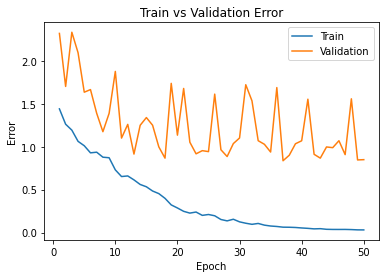

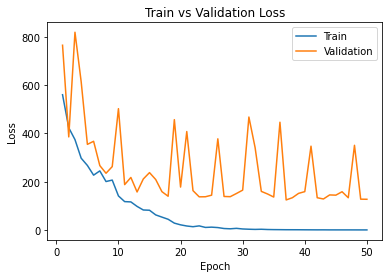

In [129]:
model_path = get_model_name("cnn", batch_size=bsize, learning_rate=lrate, epoch=numep-1)
plot_training_curve(model_path)

In [37]:
def imglabel(img0,grx,gry,channels): #function to plot grasp point onto the image
    img=img0.copy()
    for c in channels:
        img[grx,gry,:]=0
        img[grx+1,gry,:]=0
        img[grx-1,gry,:]=0
        img[grx,gry+1,:]=0
        img[grx,gry-1,:]=0
        img[grx+1,gry+1,:]=0
        img[grx-1,gry+1,:]=0
        img[grx-1,gry+1,:]=0
        img[grx+1,gry-1,:]=0
        img[grx+2,gry,:]=0
        img[grx-2,gry,:]=0
        img[grx,gry+2,:]=0
        img[grx,gry-2,:]=0
        img[grx,gry,c]=255
        img[grx+1,gry,c]=255
        img[grx-1,gry,c]=255
        img[grx,gry+1,c]=255
        img[grx,gry-1,c]=255
        img[grx+1,gry+1,c]=255
        img[grx-1,gry+1,c]=255
        img[grx-1,gry+1,c]=255
        img[grx+1,gry-1,c]=255
        img[grx+2,gry,c]=255
        img[grx-2,gry,c]=255
        img[grx,gry+2,c]=255
        img[grx,gry-2,c]=255
    return img

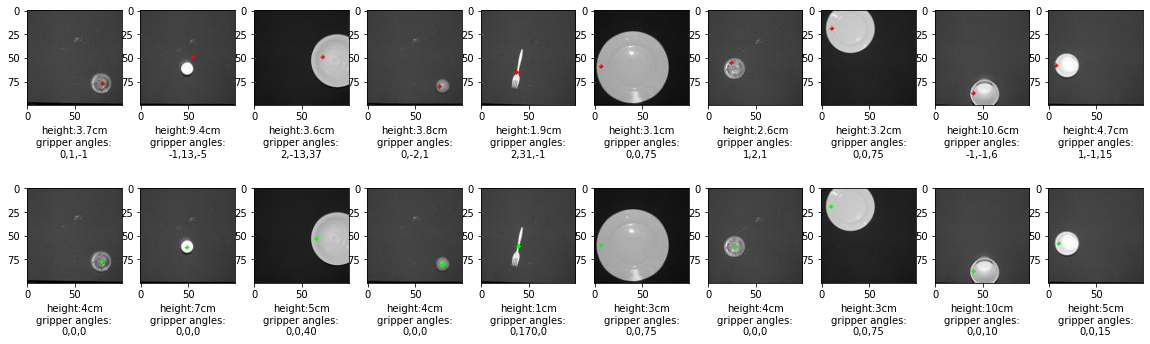

In [118]:
plt.figure(figsize=[20,6])
loopcnt=0
for i, data in enumerate(test_loader, 0):
        inputs, labels = data
        outputs = cnn(inputs)
        for j in range(10):
            img=inputs[j,0,:,:].int().detach().numpy()
            img=np.array([img,img,img])
            img=np.transpose(img,[1,2,0])
            gry=int(round(float(outputs[j,0])/55*100)) #cm to pixel
            grx=int(round(float(outputs[j,1])/55*100))
            grylb=int(round(float(labels[j,0])/55*100))
            grxlb=int(round(float(labels[j,1])/55*100))
            imgpred=imglabel(img,grx,gry,[0])
            imglab=imglabel(img,grxlb,grylb,[1])
            plt.subplot(2, 10,j+1)
            plt.imshow(imgpred)
            plt.xlabel('height:'+str(round(float(outputs[j,2]),1))+'cm'+'\ngripper angles:\n'+str(round(float(outputs[j,3])))+
                      ','+str(round(float(outputs[j,4])))+','+str(round(float(outputs[j,5]))))
            plt.subplot(2, 10,j+11)
            plt.imshow(imglab)
            plt.xlabel('height:'+str(int(round(float(labels[j,2]))))+'cm'+'\ngripper angles:\n'+str(round(float(labels[j,3])))+
                      ','+str(round(float(labels[j,4])))+','+str(round(float(labels[j,5]))))
        break
